# DATA PROJECT 

**Import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import ipywidgets as widgets
plt.style.use('seaborn-whitegrid')


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# Read and clean data

**Import package Pydst to get data using an API from Statistics Denmark**

In [30]:
#pip install git+https://github.com/elben10/pydst 
#to run this the above code needs to be installed in terminal
import pydst
Dst = pydst.Dst(lang='en')
Dst.get_subjects()

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,04,"Labour, income and wealth",True,True
2,06,Prices and consumption,True,True
3,05,Living conditions,True,True
4,14,National accounts and government finances,True,True
5,03,Education and knowledge,True,True
6,11,Business sectors,True,True
7,07,Business sector in general,True,True
8,16,Money and credit market,True,True
9,13,External economy,True,True


In [3]:
Dst = pydst.Dst(lang='en')
# printing list of subjects in the DST database
Dst.get_subjects()
# We're interested in the labour marking which is a part the subject 'Labour, income and wealth' with id=04
tables = Dst.get_tables(subjects=['04'])

## Getting data from table: AUS07

In [4]:
# In the subject 'Labour, income and wealth' we're interested in employment and unemployment
# We would like to describe the effect of COVID-19 on employment and unemployment.
# Therefore we would need a datasource which published more frequently than a yearly basis
# the table AUS07 is published monthly and contains gross unemployment (both seasonally adjusted and actual) by sex and age
# gross unemployment covers non-activated unemployed (net unemployment) and activated unemployed
data_aus07 = tables[tables.id=='AUS07']
data_aus07

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
113,AUS07,Unemployed persons (seasonally adjusted),-,2021-03-31 08:00:00,2007M01,2021M02,True,"[benefits, sex and age, seasonal adjustment an..."


In [5]:
aus_vars = Dst.get_variables(table_id='AUS07')
aus_vars

,id,text,elimination,time,values
0,YD,"benefits, sex and age",False,False,"[{'id': 'TOT', 'text': 'Gross unemployment'}, ..."
1,SAESONFAK,seasonal adjustment and actual figures,False,False,"[{'id': '9', 'text': 'Seasonally adjusted figu..."
2,Tid,time,False,True,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [6]:
for id in ['YD', 'SAESONFAK','Tid']:
    print(id)
    values = aus_vars.loc[aus_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')
# Bruttoledige består af de ikke-aktiverede (nettoledige) og aktiverede ledige.

YD
 id = TOT, text = Gross unemployment
 id = NET, text = Net unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = AKI, text = Activation total
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
 id = MEN, text = Men
 id = KVR, text = Women
 id = U25, text = 16-24 years
 id = O25, text = 25-29 years
 id = O30, text = 30-39 years
 id = O40, text = 40-49 years
 id = O50, text = 50-59 years
 id = O60, text = 60 years and more
SAESONFAK
 id = 9, text = Seasonally adjusted figures in percent of the labour force
 id = 10, text = Seasonally adjusted
 id = 22, text = Enumerated actual figures  in percent of the labour force
 id = 24, text = Enumerated actual figures
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 20

In [7]:
#### do we need this part?
variables = {'YD': ['TOT'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07 = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07 = aus07.iloc[:,2:] #dropping column 'YD'

aus07['TID'] = aus07['TID'].str.replace(r'\D', '')
aus07['TID'] =  pd.to_datetime(aus07['TID'],
                              format='%Y%m')
aus07.head()

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,TID,INDHOLD
0,2008-11-01,79298.9
1,2008-12-01,85631.1
2,2009-01-01,92165.2
3,2009-02-01,101461.8
4,2009-03-01,111313.7


### Different data from AUS07 (gender)

In [8]:
# pulling from the same datasource, now with gender
variables = {'YD': ['TOT','MEN', 'KVR'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07g = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07g = aus07g.drop(['SAESONFAK'], axis=1)

aus07g['TID'] = aus07g['TID'].str.replace(r'\D', '')
aus07g['TID'] =  pd.to_datetime(aus07g['TID'],
                              format='%Y%m')
aus07g.head()

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,YD,TID,INDHOLD
0,Gross unemployment,2008-11-01,79298.9
1,Men,2008-11-01,41784.7
2,Women,2008-11-01,37514.2
3,Gross unemployment,2008-12-01,85631.1
4,Men,2008-12-01,46140.0


### Different data from AUS07 (age)

In [9]:
# pulling from the same datasource, now with age
variables = {'YD': ['TOT','U25', 'O25', 'O30', 'O40', 'O50', 'O60'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07a = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07a = aus07a.drop(['SAESONFAK'], axis=1)
#aus07g = aus07.iloc[:,2:] #dropping column 'YD'
aus07a['TID'] = aus07a['TID'].str.replace(r'\D', '')
aus07a['TID'] =  pd.to_datetime(aus07a['TID'],
                              format='%Y%m')
aus07a.head()

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,YD,TID,INDHOLD
0,Gross unemployment,2008-11-01,79298.9
1,16-24 years,2008-11-01,9691.3
2,25-29 years,2008-11-01,10757.5
3,30-39 years,2008-11-01,21992.2
4,40-49 years,2008-11-01,18097.3


In [31]:
aup02_vars = Dst.get_variables(table_id='AUP02')
aup02_vars

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,ALDER,age,True,False,NaN,"[{'id': 'TOT', 'text': 'Age, total'}, {'id': '..."
2,KØN,sex,True,False,NaN,"[{'id': 'TOT', 'text': 'Total'}, {'id': 'M', '..."
3,Tid,time,False,True,NaN,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [32]:
for id in ['ALDER', 'KØN','Tid']:
    print(id)
    values = aup02_vars.loc[aup02_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

ALDER
 id = TOT, text = Age, total
 id = 16-24, text = 16-24 years
 id = 25-29, text = 25-29 years
 id = 30-39, text = 30-39 years
 id = 40-49, text = 40-49 years
 id = 50-59, text = 50-59 years
 id = 6099, text = 60 year and over
KØN
 id = TOT, text = Total
 id = M, text = Men
 id = K, text = Women
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 2007M05, text = 2007M05
 id = 2007M06, text = 2007M06
 id = 2007M07, text = 2007M07
 id = 2007M08, text = 2007M08
 id = 2007M09, text = 2007M09
 id = 2007M10, text = 2007M10
 id = 2007M11, text = 2007M11
 id = 2007M12, text = 2007M12
 id = 2008M01, text = 2008M01
 id = 2008M02, text = 2008M02
 id = 2008M03, text = 2008M03
 id = 2008M04, text = 2008M04
 id = 2008M05, text = 2008M05
 id = 2008M06, text = 2008M06
 id = 2008M07, text = 2008M07
 id = 2008M08, text = 2008M08
 id = 2008M09, text = 2008M09
 id = 2008M10, text = 2008M10
 id = 2008M11, text = 2008M11
 id =

In [46]:
# pulling from the same datasource, now with age
variables = {'ALDER': ['*'], 'KØN': ['*'],'Tid': ['*']}
aup02 = Dst.get_data(table_id = 'AUP02', variables = variables)
aup02 = aup02.drop(['OMRÅDE'], axis=1)

aup02['TID'] = aup02['TID'].str.replace(r'\D', '')
aup02['TID'] =  pd.to_datetime(aup02['TID'],
                              format='%Y%m')
# need to drop pre 2008
aup02.head(25)

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,ALDER,KØN,TID,INDHOLD
0,16-24 years,Women,2007-01-01,2.8
1,16-24 years,Men,2007-01-01,2.2
2,16-24 years,Total,2007-01-01,2.5
3,25-29 years,Women,2007-01-01,7.2
4,25-29 years,Men,2007-01-01,4.6
5,25-29 years,Total,2007-01-01,5.9
6,30-39 years,Women,2007-01-01,7.3
7,30-39 years,Men,2007-01-01,4.2
8,30-39 years,Total,2007-01-01,5.7
9,40-49 years,Women,2007-01-01,5.0


# KAN VI IKKE BARE HENTE FRA AUS07 EN GANG?

## Getting data from table: LBESK03

In [10]:
# getting data of employment (still from subject 04)
# LBESK03 contains (seasonally adjusted and actual) amount of employees by industry
data_lbesk03 = tables[tables.id=='LBESK03']
data_lbesk03
lbesk_vars = Dst.get_variables(table_id='LBESK03')
lbesk_vars

,id,text,elimination,time,values
0,BRANCHEDB071038,industry (DB07 10- and 19-grouping),True,False,"[{'id': 'TOT', 'text': 'TOT Industry, total'},..."
1,Tid,time,False,True,"[{'id': '2008M01', 'text': '2008M01'}, {'id': ..."


In [11]:
for id in ['BRANCHEDB071038','Tid']:
    print(id)
    values = lbesk_vars.loc[lbesk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')


BRANCHEDB071038
 id = TOT, text = TOT Industry, total
 id = 1, text = 1 Agriculture, forestry and fishing
 id = A, text = A Agriculture, forestry and fishing
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = B, text = B Mining and quarrying
 id = C, text = C Manufacturing
 id = D, text = D Electricity, gas, steam and air conditioning supply
 id = E, text = E Water supply, sewerage and waste management
 id = 3, text = 3 Construction
 id = F, text = F Construction
 id = 4, text = 4 Trade and transport etc.
 id = G, text = G Wholesale and retail trade
 id = H, text = H Transportation
 id = I, text = I Accommodation and food service activities
 id = 5, text = 5 Information and communication
 id = J, text = J Information and communication
 id = 6, text = 6 Financial and insurance
 id = K, text = K Financial and insurance
 id = 7, text = 7 Real estate
 id = L, text = L Real estate activities
 id = 8, text = 8 Other business services
 id = M, text = M Knowledge

In [12]:

variables = {'BRANCHEDB071038': ['TOT', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'X'],'Tid': ['*']}
lbesk03 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk03.head()

##### BEHØVER VI LBESK031? VI KAN VEL BARE TAGE DEN DIREKTE FRA LBESK03#####
variables = {'BRANCHEDB071038': ['TOT'],'Tid': ['*']}
lbesk031 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk031.head()

lbesk03['TID'] = lbesk03['TID'].str.replace(r'\D', '')
lbesk03['TID'] =  pd.to_datetime(lbesk03['TID'],
                              format='%Y%m')


lbesk031['TID'] = lbesk031['TID'].str.replace(r'\D', '')
lbesk031['TID'] =  pd.to_datetime(lbesk031['TID'],
                              format='%Y%m')
lbesk03.head(100)

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


,BRANCHEDB071038,TID,INDHOLD
0,"A Agriculture, forestry and fishing",2018-09-01,42578
1,B Mining and quarrying,2018-09-01,4616
2,C Manufacturing,2018-09-01,305186
3,"D Electricity, gas, steam and air conditioning...",2018-09-01,10412
4,"E Water supply, sewerage and waste management",2018-09-01,11745
...,...,...,...
95,L Real estate activities,2019-01-01,40252
96,M Knowledge-based services,2019-01-01,150361
97,"N Travel agent, cleaning, and other operatione...",2019-01-01,156414
98,"O Public administration, defence and compulsor...",2019-01-01,144829


## Getting data from table: LSK01

In [13]:
# LSK01 is a table containing vacancies
# This table is based on a questionaire
# VI SKAL BRUGE DATA FRA LSK03 DER HAR SÆSONJUSTERET DATA
# MÅSKE ER ANDEL I VIRKELIGHEDEN ENDNU MERE INTERESSANT? SIGER NOGET OM HVILKEN BRANCHE DER MANGLER ARBEJDSKRAFT OG HVILKE DER ER MERE MÆTTEDE
data_lsk01 = tables[tables.id=='LSK01']
data_lsk01
lsk_vars = Dst.get_variables(table_id='LSK01')
lsk_vars

,id,text,elimination,time,values
0,BRANCHE,industry,True,False,"[{'id': '0', 'text': 'Total'}, {'id': '2', 'te..."
1,ENHED,unit,False,False,"[{'id': 'LS', 'text': 'Job vacancies (number)'..."
2,STØRRELSE,size,True,False,"[{'id': '000', 'text': 'Workplaces total'}, {'..."
3,Tid,time,False,True,"[{'id': '2010K1', 'text': '2010Q1'}, {'id': '2..."


In [14]:
for id in ['BRANCHE','ENHED', 'Tid']:
    print(id)
    values = lsk_vars.loc[lsk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

BRANCHE
 id = 0, text = Total
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = 3, text = 3 Construction
 id = 4, text = 4 Trade and transport etc.
 id = 5, text = 5 Information and communication
 id = 6-7, text = 6-7 Financial, insurance and real estate
 id = 8, text = 8 Other business services
ENHED
 id = LS, text = Job vacancies (number)
 id = ALS, text = Job vacancy rate (per cent)
Tid
 id = 2010K1, text = 2010Q1
 id = 2010K2, text = 2010Q2
 id = 2010K3, text = 2010Q3
 id = 2010K4, text = 2010Q4
 id = 2011K1, text = 2011Q1
 id = 2011K2, text = 2011Q2
 id = 2011K3, text = 2011Q3
 id = 2011K4, text = 2011Q4
 id = 2012K1, text = 2012Q1
 id = 2012K2, text = 2012Q2
 id = 2012K3, text = 2012Q3
 id = 2012K4, text = 2012Q4
 id = 2013K1, text = 2013Q1
 id = 2013K2, text = 2013Q2
 id = 2013K3, text = 2013Q3
 id = 2013K4, text = 2013Q4
 id = 2014K1, text = 2014Q1
 id = 2014K2, text = 2014Q2
 id = 2014K3, text = 2014Q3
 id = 2014K4, text = 2014Q4
 id = 2015K1, t

In [15]:
#udvalgte brancher
variables = {'BRANCHE': ['0','2', '3', '4', '5', '6-7', '8'], 'Enhed': ['LS'], 'Tid': ['*']}
lsk01 = Dst.get_data(table_id = 'LSK01', variables = variables)
lsk01.head()

,BRANCHE,ENHED,TID,STØRRELSE,INDHOLD
0,Total,Job vacancies (number),2010Q1,Workplaces total,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",Job vacancies (number),2010Q1,Workplaces total,2854.0
2,3 Construction,Job vacancies (number),2010Q1,Workplaces total,1362.0
3,4 Trade and transport etc.,Job vacancies (number),2010Q1,Workplaces total,7857.0
4,5 Information and communication,Job vacancies (number),2010Q1,Workplaces total,1666.0


In [16]:
#total - branche

# VI BRUGER IKKE DEN HER TIL NOGET?

# variables = {'BRANCHE': ['0'], 'Enhed': ['LS'], 'Tid': ['*']}
# lsk011 = Dst.get_data(table_id = 'LSK01', variables = variables)

# lsk011['TID'] =  pd.to_datetime(lsk011['TID'])
# lsk011['TID'] = lsk011['TID'] + pd.offsets.QuarterEnd(0)
# lsk011.head()

,BRANCHE,ENHED,TID,STØRRELSE,INDHOLD
0,Total,Job vacancies (number),2010-03-31,Workplaces total,19094.0
1,Total,Job vacancies (number),2010-06-30,Workplaces total,20019.0
2,Total,Job vacancies (number),2010-09-30,Workplaces total,19932.0
3,Total,Job vacancies (number),2010-12-31,Workplaces total,17508.0
4,Total,Job vacancies (number),2011-03-31,Workplaces total,19935.0


In [17]:
lsk01.rename(columns = {'INDHOLD': 'jobvacancies', 'TID': 'TIME', 'BRANCHE': 'branche'}, inplace = True)
lsk01 = lsk01.drop(['ENHED', 'STØRRELSE'], axis=1)
lsk01.head(100)

,branche,TIME,jobvacancies
0,Total,2010Q1,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",2010Q1,2854.0
2,3 Construction,2010Q1,1362.0
3,4 Trade and transport etc.,2010Q1,7857.0
4,5 Information and communication,2010Q1,1666.0
...,...,...,...
95,5 Information and communication,2013Q2,2469.0
96,"6-7 Financial, insurance and real estate",2013Q2,1306.0
97,8 Other business services,2013Q2,5581.0
98,Total,2013Q3,21175.0


In [18]:
lsk01['TIME'] =  pd.to_datetime(lsk01['TIME'])
lsk01['TIME'] = lsk01['TIME'] + pd.offsets.QuarterEnd(0)
lsk01.head(100)

,branche,TIME,jobvacancies
0,Total,2010-03-31,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",2010-03-31,2854.0
2,3 Construction,2010-03-31,1362.0
3,4 Trade and transport etc.,2010-03-31,7857.0
4,5 Information and communication,2010-03-31,1666.0
...,...,...,...
95,5 Information and communication,2013-06-30,2469.0
96,"6-7 Financial, insurance and real estate",2013-06-30,1306.0
97,8 Other business services,2013-06-30,5581.0
98,Total,2013-09-30,21175.0


In [19]:
###### HVAD BRUGER VI DET HER TIL?
lsk01['branch'] = lsk01['branche'].str[:1]
lsk01.head()

,branche,TIME,jobvacancies,branch
0,Total,2010-03-31,19094.0,T
1,"2 Manufacturing, mining and quarrying, and uti...",2010-03-31,2854.0,2
2,3 Construction,2010-03-31,1362.0,3
3,4 Trade and transport etc.,2010-03-31,7857.0,4
4,5 Information and communication,2010-03-31,1666.0,5


# Merge data sets

In [20]:
dstmerge = pd.merge(aus07, lbesk03, how='outer', on=['TID']);
dstmerge.rename(columns = {'INDHOLD_x': 'Unemployed', 'INDHOLD_y': 'Employed', 'TID': 'TIME', 'BRANCHEDB071038': 'BRANCH'}, inplace = True)

#### HVAD BRUGER VI NEDENSTÅENDE TIL?
dstmerge['branch'] = dstmerge['BRANCH'].str[:1]
dstmerge.head()


,TIME,Unemployed,BRANCH,Employed,branch
0,2008-11-01,79298.9,"A Agriculture, forestry and fishing",38581.0,A
1,2008-11-01,79298.9,B Mining and quarrying,4780.0,B
2,2008-11-01,79298.9,C Manufacturing,363401.0,C
3,2008-11-01,79298.9,"D Electricity, gas, steam and air conditioning...",12108.0,D
4,2008-11-01,79298.9,"E Water supply, sewerage and waste management",11739.0,E


In [21]:
# Removing pre 2008 as there are empty cells
dstmerge = dstmerge.dropna(axis=0)
dstmerge = dstmerge.sort_values('TIME')

In [22]:
dstmerge.head()

,TIME,Unemployed,BRANCH,Employed,branch
127,2008-01-01,80416.2,X Activity not stated,1425.0,X
126,2008-01-01,80416.2,"TOT Industry, total",2716275.0,T
125,2008-01-01,80416.2,S Other service activities etc.,61016.0,S
124,2008-01-01,80416.2,"R Arts, entertainment and recreation activities",45329.0,R
123,2008-01-01,80416.2,Q Human health and social work,483388.0,Q


# Data Analysis

In this project we have used data from Statistics Denmark. We have collected data by using their API, where we have extracted data on the gross unemployment and the employment since 2008, by the tables: AUS07, LBESK01. Furthermore, we have collected data regarding job vacancies from the table LSK01.

The gross unemployment are defined as the number of net unemployed and persons in activation. The employment data is based on the total number of employees per month and the number of employed in 20 branches. The data are seasonally adjusted and computed monthly data.

The data on job vacancies is based on the number of job vacanies on 6 branches since 2010, and computed quarterly.

<function matplotlib.pyplot.show(close=None, block=None)>

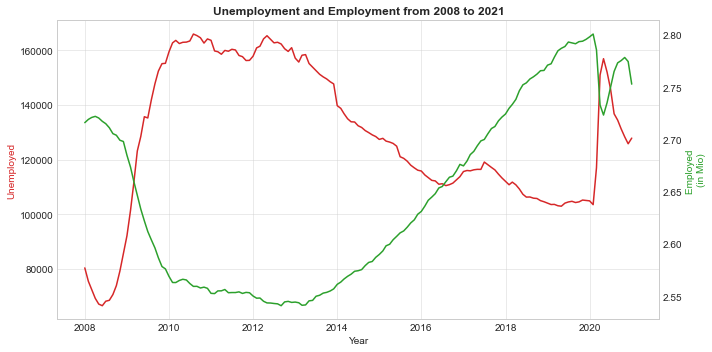

In [23]:
#Unemployment and employment from 2008 to 2021
#Data, unemployment and employment (using the subset of employment total from all industries):
x = dstmerge['TIME']
z = lbesk031['TID']
data1 = dstmerge['Unemployed']
data2 = lbesk031['INDHOLD']/1000000

#Create figure
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title(f'Unemployment and Employment from 2008 to 2021', fontweight = 'bold')
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployed', color=color)
ax1.plot(x, data1, label=f'Unemployed', color = color)

#Second axis:
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Employed \n(in mill)', color = color)
ax2.plot(z,data2, label = f'Employed', color = color)
ax2.ticklabel_format(useOffset=False, style='plain', axis='y')

ax1.grid(alpha = 0.5)
ax2.grid(None)

#To avoid the right y-label is clipped:
fig.tight_layout()

plt.show

Figure 1 illustrated that when the Financial Crisis hit in 2008 the gross unemployment rose from 68,223 in July 2008 to the peak at 165,994.2 in August of 2010, which is an 143 percent increase in unemployment in the given period. From August 2010 to May 2012 the number of unemployed is stabilized around 165,000.0 unemployed. The unemployment has from May 2012 to September 2017 continued to fall to the level around 110.000 unemployed, until the effect of lock-down due to COVID-19 hits the employment numbers in February 2020. In March 2020 the unemployment increases rapidly to 156,973.3 in May 2020, which is a 52.4 percent increase in unemployment. An increase in employment on 150.000 appears from May to December 2020 approximately, which might be due to the Danish Governments fiscal policy and the fact the many lock-down restrictions was dropped from August to December 2020. Furthermore, there is an inverse relationship between the development in unemployed and employed, but is not 1-1 due to a worker can drop out of or enter the labor force.

## Unemployment

### Unemployment on gender

In [24]:
#unemployed - gender
def plot_gender(aus07g, gender):
    I = aus07g['YD'] == gender
    temp = aus07g.copy()
    temp = temp.loc[I,:]
    temp = temp.sort_values('TID')
    
    # Storing relevant variables
    x = temp['TID']
    y1 = temp['INDHOLD']
    temp = aus07g.loc[aus07g['YD']=='Gross unemployment',['TID', 'INDHOLD']].sort_values('TID')
    y2 = temp['INDHOLD'] 
    
     # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish uemployment by gender', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Unemployed by gender', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Gross Unemployment', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)
    


# creating options for the interactive figure
opt = aus07g.YD.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Gross unemployment'))
    
    
widgets.interact(plot_gender,
    aus07g = widgets.fixed(aus07g),
    gender = widgets.Dropdown(description='Gender', 
                                options=opt,
                                value='Women')
);

interactive(children=(Dropdown(description='Gender', index=1, options=('Men', 'Women'), value='Women'), Output…

In [47]:
aup02.head(25)

,ALDER,KØN,TID,INDHOLD
0,16-24 years,Women,2007-01-01,2.8
1,16-24 years,Men,2007-01-01,2.2
2,16-24 years,Total,2007-01-01,2.5
3,25-29 years,Women,2007-01-01,7.2
4,25-29 years,Men,2007-01-01,4.6
5,25-29 years,Total,2007-01-01,5.9
6,30-39 years,Women,2007-01-01,7.3
7,30-39 years,Men,2007-01-01,4.2
8,30-39 years,Total,2007-01-01,5.7
9,40-49 years,Women,2007-01-01,5.0


In [60]:
#unemployed - age
def plot_age(aup02, age):
    I = aup02['KØN'] == 'Total'
    temp_df = aup02.loc[I,:]
    I = temp_df['ALDER'] == age
    temp = temp_df.loc[I,:]
    temp = temp.sort_values('TID')
    # storing relevant values
    x = temp['TID']
    y1 = temp['INDHOLD']
    y12 = temp.loc[:,['INDHOLD']].rolling(window = 13, center = True).mean()       #df['pandas_SMA_4'] = df.iloc[:,1].rolling(window=4).mean()
    temp_df = temp_df.loc[temp_df['ALDER']=='Age, total', ['INDHOLD', 'TID']].sort_values('TID')
    y2 = temp_df['INDHOLD']    
    y22 = temp_df.loc[:,['INDHOLD']].rolling(window = 13, center = True).mean()
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Full-time uemployed as share of workforce, by age', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Full-time uemployed as share of workforce, by age', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    ax1.plot(x,y12, color = color1, linestyle='dashed', label = f'13 month centered MA')
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Full-time unemployed as share of workforce', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.plot(x,y22, color = color2, linestyle = 'dashed', label = f'13 month centered MA')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    plt.legend()
#     ax2.legend()
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)

    

# creating options for the interactive figure
opt = aup02.ALDER.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Age, total'))

widgets.interact(plot_age,
    aup02 = widgets.fixed(aup02),
    age = widgets.Dropdown(description='Age', 
                                options=opt,
                                value='16-24 years')
);

interactive(children=(Dropdown(description='Age', options=('16-24 years', '25-29 years', '30-39 years', '40-49…

### Unemployment on age

In [25]:
#unemployed - age
def plot_age(aus07a, age):
    I = aus07a['YD'] == age
    temp = aus07a.copy()
    temp = temp.loc[I,:]
    temp = temp.sort_values('TID')
    # storing relevant values
    x = temp['TID']
    y1 = temp['INDHOLD']
    temp = aus07a.loc[aus07a['YD']=='Gross unemployment', ['INDHOLD', 'TID']].sort_values('TID')
    y2 = temp['INDHOLD']    
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish uemployment by age', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Unemployed by age', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Gross Unemployment', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)

    

# creating options for the interactive figure
opt = aus07a.YD.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Gross unemployment'))

widgets.interact(plot_age,
    aus07a = widgets.fixed(aus07a),
    age = widgets.Dropdown(description='Age', 
                                options=opt,
                                value='16-24 years')
);

interactive(children=(Dropdown(description='Age', options=('16-24 years', '25-29 years', '30-39 years', '40-49…

## Employment

In [27]:
def _plot_timeseries(dataframe, variable, dates):
    # Formatting date for compatibility
    temp = dataframe.copy()
    temp['date'] = temp['TIME'].dt.date
    
    # subsetting data properly
    I = (temp['date'] >= dates[0]) & (temp['date'] <= dates[1])
    temp = temp.loc[I,['date', 'BRANCH', 'Employed']]
    temp1 = temp.copy()
    
    I = temp['BRANCH'] == variable
    temp = temp.loc[I,:]
    
    # Plotting second subset of dataframe
    x = temp['date']
    y1 = temp['Employed']
    I = temp1['BRANCH'] == 'TOT Industry, total'
    temp1 = temp1.loc[I,['date', 'Employed']].sort_values('date')
    y2 = temp1['Employed']/1000000
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish employment by sector', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Employment by sector', color = color1)
    ax1.plot(x,y1, color = color1, label = f'Employed')
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Gross Employment\n (in mill)', color = color2)
    ax2.plot(x,y2, color = color2, label = f'Employed')
    ax1.grid(alpha = .5)
    plt.grid(None)
    

def plot_timeseries(dataframe):
    # initializing widget parameters
    # Storing unique date values 
    date_opt = dataframe['TIME'].dt.date.unique()
    # Formatting date values
    date_opt = [(date.strftime(' %d %b %Y '), date) for date in date_opt]
    # storing unique sector categories
    sector_opt = dataframe['BRANCH'].unique()
    # removing irrelevant category (total being on second axis)
    sector_opt = np.delete(sector_opt, np.where(sector_opt == 'TOT Industry, total'))
    
    # Executing widgets
    widgets.interact(_plot_timeseries, 
    dataframe = widgets.fixed(dataframe),
    variable = widgets.Dropdown(
        description='Sector', 
        options=sector_opt, 
        value='X Activity not stated'),
    dates=widgets.SelectionRangeSlider(
        description='Period',
        options=date_opt,
        index=(0,len(date_opt)-1),
        orientation='horizontal',
        layout={'width': '500px'},
        continuous_update=False,
    )               
)

plot_timeseries(dstmerge)

interactive(children=(Dropdown(description='Sector', options=('X Activity not stated', 'S Other service activi…

## Job vacancies

In [28]:
#Job vacancies in Denmark from 2010 to 2020
#Interactive graph that shows job vacancies on the Danish labor market and subdivided into sector

def plot_vac(lsk01, branch1):
    I = lsk01['branche'] == branch1
    ax = lsk01.loc[I,:].plot(x='TIME', y='jobvacancies', style='-', legend=False)

widgets.interact(plot_vac,
    lsk01 = widgets.fixed(lsk01),
    branch1 = widgets.Dropdown(description='Sector', 
                                options=lsk01.branche.unique(),
                                value='Total')
);

interactive(children=(Dropdown(description='Sector', options=('Total', '2 Manufacturing, mining and quarrying,…

Total number of job vacancies has increased from 2010 to 2020 and we notice that during a year there is a cycle, where the number of vacancies drops around autumn. In 2012 and around 2020 the lowest number of job vacancies appears. Lower number of job vacancies implies that the demand for labor is low, as a result of less economic activity, which is the case in 2012(?) and 2020 due to covid-19, there is a large drop, which improves end of year 2020. However, when looking at different sectors, the job market responds differently towards the covid-19 crisis. In the sectors construction and Informations and Communication the demand for labor also dropped. However, the construction sector is already in the end of 2020 almost back to demanding the same level of labor as before COVID-19, whereas the demand for labor within the sector Information and Communication is lower than before COVID-19. This implies not all sectors are equally damaged by the lock-down.

# Conclusion

ADD CONCISE CONLUSION.

In [29]:
#####GRAVEYARD
#aus07a.pivot(index="TID", columns='YD' values='INDHOLD').plot()
#plt.show()

#labels = aus07g.TID.unique()
#men = aus07g[aus07g['YD']=='Men']['INDHOLD']
#women = aus07g[aus07g['YD']=='Women']['INDHOLD']
#print(men, women)

#x = np.arange(len(labels))  # the label locations
#width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
#rects1 = ax.bar(x - width/2, men, width, label='Men')
#rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

#plt.show()

#kunne laves som kurve??
#man kunne også lave det i andele (vi kigger på fordelinge)
#lav en som oluf (med køn som stablede og total som kurve)

#lunemployment - age
#lav en interaktiv på denne
#labels = aus07a.TID.unique()
#U25 = aus07a[aus07a['YD']=='16-24 years']['INDHOLD']
#O25 = aus07a[aus07a['YD']=='25-29 years']['INDHOLD']
#O30 = aus07a[aus07a['YD']=='30-39 years']['INDHOLD']
#O40 = aus07a[aus07a['YD']=='40-49 years']['INDHOLD']
#O50 = aus07a[aus07a['YD']=='50-59 years']['INDHOLD']
#O60 = aus07a[aus07a['YD']=='60 years and more']['INDHOLD']
#print(U25)

#Get data:
#labels = aus07a.TID.unique()
#aus07a[aus07a['TID']] = pd.to_datetime(aus07a[aus07a['TID']])


#x = np.arange(len(labels))
#U25 = aus07a[aus07a['YD']=='16-24 years']['INDHOLD']
#O25 = aus07a[aus07a['YD']=='25-29 years']['INDHOLD']
#O30 = aus07a[aus07a['YD']=='30-39 years']['INDHOLD']
#O40 = aus07a[aus07a['YD']=='40-49 years']['INDHOLD']
#O50 = aus07a[aus07a['YD']=='50-59 years']['INDHOLD']
#O60 = aus07a[aus07a['YD']=='60 years and more']['INDHOLD']

#width = 0.35       # the width of the bars: can also be len(x) sequence

#fig, ax = plt.subplots()
#ax.bar(x, U25, width, label='U25')
#ax.bar(x, O25, width, bottom = U25, label = 'O25')
#ax.bar(x, O30, width, label='O30')
#ax.bar(x, O40, width, bottom = O40, label = 'O40')
#ax.bar(x, O50, width, label='O50')
#ax.bar(x, O60, width, bottom = O60, label = 'O60')

#plt.show()

#fig, ax = plt.subplots(1, figsize=(16, 8))
#plt.bar(z, U25, color = '#337AE3', width =0.5)
#plt.bar(z, O25, bottom = U25, color = '#5E96E9', width =0.5)
#plt.bar(z, O30, color = '#DB4444', width =0.5)
#plt.bar(z, O40, bottom = O30, color = '#E17979', width =0.5)
#plt.bar(z, O50, color = '#337AE3', width =0.5)
#plt.bar(z, O60, bottom = O50, color = '#5E96E9', width =0.5)

# x and y limits
#plt.xlim(-0.6, 10.5)
#plt.ylim(-1600, 2000)
# remove spines
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#grid
#ax.set_axisbelow(True)
#ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)
# x ticks
#xticks_labels = ['Jan', 'Fev', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
#plt.xticks(result_df.index , labels = xticks_labels)
# title and legend
#legend_label = ['Sales Revenue', 'Interest Revenue', 'Variable Costs', 'Fixed Costs']
#plt.legend(legend_label, ncol = 4, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)

#print(aus07a[aus07a['TID']])

#print(aus07a['TID'])
#print(U25)


#aus07a[aus07a['TID']] = pd.to_datetime(aus07a[aus07a['TID']])